# Rpb1$^{\mathrm{SNAP549}}$ bindint to DNA$^{488}$

Fig. 2 in [Dynamics of RNA polymerase II and elongation factor Spt4/5 recruitment during activator-dependent transcription](https://www.pnas.org/content/117/51/32348)

## Setup

In [1]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path

import pyro
import pyro.distributions as dist
from pyro.ops.stats import pi, resample
from pyro.infer import Predictive

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from tapqir.models import Cosmos, HMM
from tapqir.imscroll.glimpse_reader import GlimpseDataset
from tapqir.utils.imscroll import time_to_first_binding

from tapqir.utils.stats import ci_from_trace
from tapqir.utils.mle_analysis import train, ttfb_model, ttfb_guide

## View Data

### DNA channel

In [2]:
dna_path_data = Path("/shared/centaur/data/GraceArticleDNA/")
dna_glimpse = GlimpseDataset(dna_path_data)

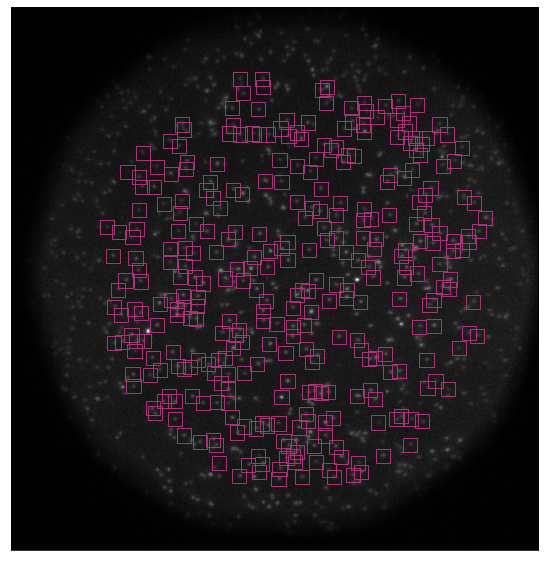

In [3]:
plt.figure(figsize=(10, 10))

# average 5 frames
dna_channel = dna_glimpse[116:121].mean(0)
# plot selected area of the image
plt.imshow(dna_channel[:, 500:], cmap="gray")

for aoi in dna_glimpse.aoiinfo["test"].index:
    # on-target area
    y_pos = round(dna_glimpse.aoiinfo["test"].at[aoi, "y"] - 6.5) - 0.5 - 500
    x_pos = round(dna_glimpse.aoiinfo["test"].at[aoi, "x"] - 6.5) - 0.5
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14,
                                  edgecolor="#AA3377", lw=1, facecolor="none"))

plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [4]:
# load glimpse
path_data = Path("/shared/centaur/data/GraceArticlePol2/")
glimpse = GlimpseDataset(path_data)

# load model & parameters
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs16"
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

### AOIs

In [5]:
glimpse.aoiinfo["test"]

,frame,ave,x,y,pixnum
aoi,,,,,
1,1.0,2.0,74.327951,720.186133,10.0
2,1.0,2.0,74.228918,742.830400,10.0
3,1.0,2.0,81.886142,805.971494,10.0
4,1.0,2.0,82.314306,743.127017,10.0
5,1.0,2.0,85.174309,800.671167,10.0
...,...,...,...,...,...
327,1.0,2.0,467.206446,718.514678,10.0
328,1.0,2.0,467.840212,780.243755,10.0
329,1.0,2.0,468.122318,811.632774,10.0


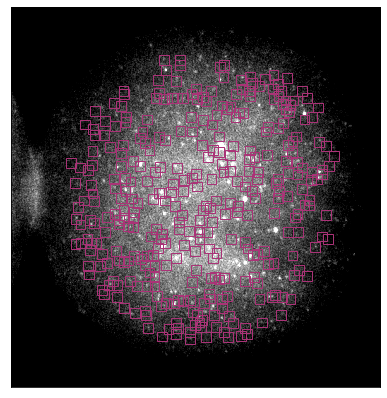

In [6]:
plt.figure(figsize=(7, 7))

frame = 635
# plot selected area of the image
plt.imshow(glimpse[frame][:, 500:], cmap="gray",
           vmin=model.data.vmin, vmax=model.data.vmax)

for aoi in glimpse.aoiinfo["test"].index:
    # on-target area
    y_pos = round(glimpse.aoiinfo["test"].at[aoi, "y"]
                  + glimpse.cumdrift.at[frame, "dy"] - 6.5) - 0.5 - 500
    x_pos = round(glimpse.aoiinfo["test"].at[aoi, "x"]
                  + glimpse.cumdrift.at[frame, "dx"] - 6.5) - 0.5
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14,
                                  edgecolor="#AA3377", lw=1, facecolor="none"))

plt.xticks([], [])
plt.yticks([], [])
plt.show()

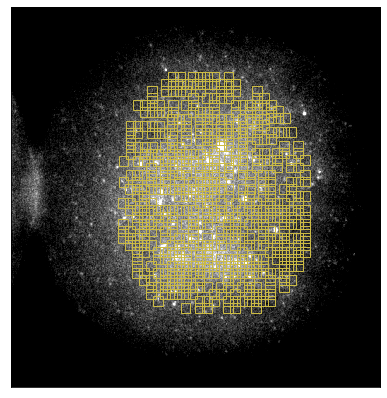

In [7]:
plt.figure(figsize=(7, 7))

frame = 635
# plot selected area of the image
plt.imshow(glimpse[frame][:, 500:], cmap="gray",
           vmin=model.data.vmin, vmax=model.data.vmax)

for aoi in glimpse.aoiinfo["control"].index:
    # off-target area
    y_pos = round(glimpse.aoiinfo["control"].at[aoi, "y"]
                  + glimpse.cumdrift.at[frame, "dy"] - 6.5) - 0.5 - 500
    x_pos = round(glimpse.aoiinfo["control"].at[aoi, "x"]
                  + glimpse.cumdrift.at[frame, "dx"] - 6.5) - 0.5
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14,
                                  edgecolor="#CCBB44", lw=1, facecolor="none"))

plt.xticks([], [])
plt.yticks([], [])
plt.show()

### Driftlist

In [8]:
glimpse.cumdrift

,dx,dy
frame,,
1,0.000000,0.000000
2,-0.148922,0.036834
3,-0.247581,0.061577
4,-0.288043,0.071932
5,-0.301972,0.074633
...,...,...
786,0.261474,-4.275180
787,0.262331,-4.293345
788,0.330751,-4.313323


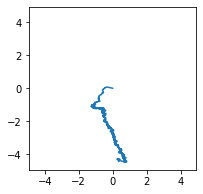

In [9]:
plt.figure(figsize=(3,3))
plt.plot(glimpse.cumdrift["dx"], glimpse.cumdrift["dy"])
lim = glimpse.cumdrift.abs().max().max() * 1.1
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

### Offset

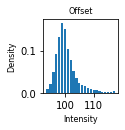

In [10]:
plt.figure(figsize=(1.35,1.35))
plt.bar(model.data.offset_samples, model.data.offset_weights)
plt.title("Offset", fontsize=8)
plt.ylabel("Density", fontsize=8)
plt.xlabel("Intensity", fontsize=8)
plt.show()

### Global parameters

In [11]:
fit = pd.read_csv(
            path_params / "statistics.csv",
            squeeze=True,
            index_col=0
        ).rename("GraceArticlePol2")
fit

snr                1.6084014177322388
gain_mean           6.436908721923828
gain_ll             6.436908721923828
gain_ul             6.436908721923828
pi_mean           0.11116861552000046
pi_ll             0.11116861552000046
pi_ul             0.11116861552000046
lamda_mean        0.31507036089897156
lamda_ll          0.31507036089897156
lamda_ul          0.31507036089897156
proximity_mean     0.5827454924583435
proximity_ll       0.5827454924583435
proximity_ul       0.5827454924583435
marginal                         True
classifier                      False
MCC                0.8475815798260188
Recall             0.7872758886070177
Precision          0.9518230064098145
TN                             225009
FP                               1398
FN                               7463
TP                              27620
z_median           0.9249193072319031
z_ll               0.1570589542388916
z_ul               0.9626879096031189
Name: GraceArticlePol2, dtype: object

## Figures

### Figure 1

In [12]:
ontarget = 163
offtarget = 282
frames = [625, 630, 635, 640, 645]
vmin, vmax = 340, 635

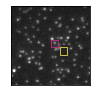

In [13]:
plt.figure(figsize=(1.45, 1.45))

# average 5 frames
dna_channel = dna_glimpse[116:121].mean(0)
# plot selected area of the image
plt.imshow(dna_channel[200:350, 630:780], cmap="gray",
           vmin=120, vmax=400)


# on-target AOI
aoi = glimpse.aoiinfo["test"].index[ontarget]
y_pos = round(dna_glimpse.aoiinfo["test"].at[aoi, "y"] - 6.5) - 0.5 - 630
x_pos = round(dna_glimpse.aoiinfo["test"].at[aoi, "x"] - 6.5) - 0.5 - 200
plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14,
                              edgecolor="#AA3377", lw=1, facecolor="none"))
# plt.scatter(dna_glimpse.aoiinfo["test"].at[aoi, "y"]-630, dna_glimpse.aoiinfo["test"].at[aoi, "x"]-200)

# off-target AOI
aoi2 = glimpse.aoiinfo["control"].index[offtarget]
y_adj = - glimpse.aoiinfo["test"].at[aoi, "y"] + glimpse.aoiinfo["control"].at[aoi2, "y"]
y_pos = round(dna_glimpse.aoiinfo["test"].at[aoi, "y"] + y_adj - 6.5) - 0.5 - 630
x_adj = - glimpse.aoiinfo["test"].at[aoi, "x"] + glimpse.aoiinfo["control"].at[aoi2, "x"]
x_pos = round(dna_glimpse.aoiinfo["test"].at[aoi, "x"] + x_adj - 6.5) - 0.5 - 200
plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14,
                              edgecolor="#CCBB44", lw=1, facecolor="none"))

plt.xticks([], [])
plt.yticks([], [])
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure1/blue.png", dpi=600)
plt.show()

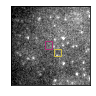

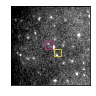

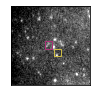

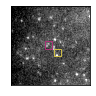

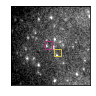

In [14]:
for f in frames:
    frame = glimpse.cumdrift.index[f]
    plt.figure(figsize=(1.45, 1.45))

    # plot selected area of the image
    plt.imshow(glimpse[frame][200:350, 630:780], cmap="gray",
               vmin=vmin, vmax=vmax)

    # on-target area
    aoi = glimpse.aoiinfo["test"].index[ontarget]
    y_pos = round(glimpse.aoiinfo["test"].at[aoi, "y"]
                  + glimpse.cumdrift.at[frame, "dy"] - 6.5) - 0.5 - 630
    x_pos = round(glimpse.aoiinfo["test"].at[aoi, "x"]
                  + glimpse.cumdrift.at[frame, "dx"] - 6.5) - 0.5 - 200
    plt.gca().add_patch(Rectangle((y_pos, x_pos), model.data.D, model.data.D,
                                  edgecolor="#AA3377", lw=1, facecolor="none"))

    # off-target area
    aoi = glimpse.aoiinfo["control"].index[offtarget]
    y_pos2 = round(glimpse.aoiinfo["control"].at[aoi, "y"]
                  + glimpse.cumdrift.at[frame, "dy"] - 6.5) - 0.5 - 630
    x_pos2 = round(glimpse.aoiinfo["control"].at[aoi, "x"]
                  + glimpse.cumdrift.at[frame, "dx"] - 6.5) - 0.5 - 200
    plt.gca().add_patch(Rectangle((y_pos2, x_pos2), model.data.D, model.data.D,
                                  edgecolor="#CCBB44", lw=1, facecolor="none"))

    plt.xticks([], [])
    plt.yticks([], [])
    # plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure1/green{f}.png", dpi=600)
    plt.show()

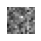

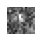

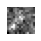

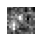

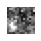

In [15]:
frames = [625, 630, 635, 640, 645]

for f in frames:
    plt.figure(figsize=(0.5, 0.5))
    plt.axis("off")
    plt.imshow(model.data[ontarget, f].numpy(),
               vmin=vmin, vmax=vmax, cmap="gray")
    # plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure1//dna{f}.png", dpi=600)
    plt.show()

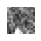

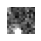

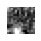

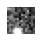

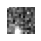

In [16]:
for f in frames:
    plt.figure(figsize=(0.5, 0.5))
    plt.axis("off")
    plt.imshow(model.control[offtarget, f].numpy(),
               vmin=vmin, vmax=vmax, cmap="gray")
    # plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure1/nondna{f}.png", dpi=600)
    plt.show()

### Figure 2

In [17]:
path_data = Path("/shared/centaur/data/GraceArticlePol2/")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs16"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

In [18]:
n = ontarget
f = 640

X = Y = np.arange(model.data.D) - (model.data.D - 1) / 2
X, Y = np.meshgrid(X, Y)

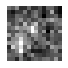

In [19]:
plt.figure(figsize=(1., 1.))
plt.imshow(model.data[n, f].numpy(), vmin=vmin, vmax=vmax, cmap="gray")
plt.axis("off")
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure2/obs2d.png", dpi=600)
plt.show()

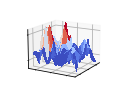

In [20]:
fig = plt.figure(figsize=(1.5, 1.5))
ax = fig.add_subplot(111, projection="3d")

Z = model.data[n, f].numpy()

# Plot the surface.
surf = ax.plot_surface(Y, X, Z, cmap=cm.coolwarm, vmin=450, vmax=570,
                       linewidth=0, antialiased=False)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
    
ax.view_init(elev=15., azim=30)
ax.set_zlim(vmin, vmax)

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure2/obs3d.png", dpi=600)

plt.show()

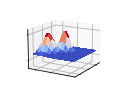

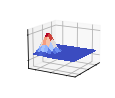

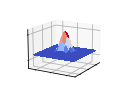

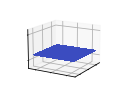

In [21]:
for m1, m2 in ((0, 0), (0, 1), (1, 0), (1, 1)):
    fig = plt.figure(figsize=(1.5, 1.5))
    ax = fig.add_subplot(111, projection="3d")

    img_ideal = model.data.offset_mean + pyro.param("d/b_loc").data[n, f:f+1, None, None]
    gaussian = model.data_loc(
        pyro.param("d/h_loc").data[:, n, f:f+1].masked_fill(torch.tensor([[m1], [m2]]), 0.),
        pyro.param("d/w_mean").data[:, n, f:f+1],
        pyro.param("d/x_mean").data[:, n, f:f+1],
        pyro.param("d/y_mean").data[:, n, f:f+1],
        n, torch.arange(f,f+1)
    )
    img_ideal = img_ideal + gaussian.sum(-4)
    Z = img_ideal[0].numpy()

    # Plot the surface.
    surf = ax.plot_surface(Y, X, Z, cmap=cm.coolwarm, vmin=450, vmax=570,
                           linewidth=0, antialiased=False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.view_init(elev=15., azim=30)
    ax.set_zlim(vmin, vmax)

    # plt.savefig(f"//home/ordabayev/repos/tapqir-overleaf/figures/figure2/model{m1}{m2}.png", dpi=600)
    plt.show()

### Figure 3

In [22]:
path_data = Path("/shared/centaur/data/GraceArticlePol2/")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs16"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

In [23]:
n = ontarget = 163
offtarget = 282
frames = [625, 628, 630, 633 , 635, 638, 640, 643, 645]
vmin, vmax = 340, 635

In [24]:
model.n = torch.tensor([n])
trace = pyro.poutine.trace(model.guide).get_trace()

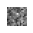

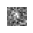

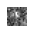

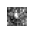

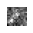

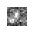

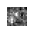

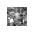

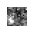

In [25]:
for f in frames:
    plt.figure(figsize=(0.35, 0.35))
    plt.axis("off")
    plt.imshow(model.data[ontarget, f].numpy(),
               vmin=vmin, vmax=vmax, cmap="gray")
    # plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-aois-{f}.png", dpi=600)
    plt.show()

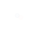

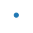

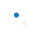

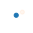

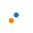

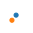

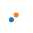

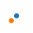

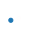

In [26]:
for f in frames:
    fig = plt.figure(figsize=(0.35, 0.35))

    plt.imshow(np.ones((model.data.D, model.data.D)),
               vmin=0, vmax=1, cmap="gray")
    # add patch
    for k in range(2):
        plt.gca().add_patch(
            Circle(
                (model.data.target_locs[n, f, 1] +
                 pyro.param("d/y_mean")[k, n, f].item(),
                 model.data.target_locs[n, f, 0] +
                 pyro.param("d/x_mean")[k, n, f].item()),
                1.5, color=f"C{k}", alpha=min(1, model.m_probs[k, n, f].item())
            )
        )
    plt.axis("off")
    # plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-{f}.png", dpi=600)
    plt.show()

In [27]:
f1, f2 = 625, 646

model.n = torch.tensor([n])
trace = pyro.poutine.trace(model.guide).get_trace()

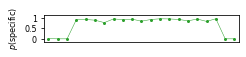

In [28]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    model.z_marginal[n, f1:f2],
    "o-", ms=2, lw=0.5, color="C2", label="on-target"
)

plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(\mathrm{specific})$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-pspecific.svg")
plt.show()

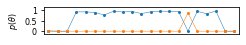

In [29]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    model.z_probs[0, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C0", label=r"$\theta=1$"
)
plt.plot(
    np.arange(f1, f2),
    model.z_probs[1, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C1", label=r"$\theta=2$"
)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(\theta)$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-theta.svg")
plt.show()

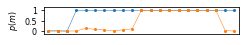

In [30]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    model.m_probs[0, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C0", label=r"$m_{1}$"
)
plt.plot(
    np.arange(f1, f2),
    model.m_probs[1, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C1", label=r"$m_{2}$"
)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(m)$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-m.svg")
plt.show()

In [31]:
sites = [
    "d/height_0",
    "d/height_1",
    "d/width_0",
    "d/width_1",
    "d/x_0",
    "d/x_1",
    "d/y_0",
    "d/y_1",
    "d/background",
]
ci_stats = ci_from_trace(trace, sites)

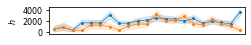

In [32]:
plt.figure(figsize=(3.5,0.5))

for k in range(2):
    plt.fill_between(
        np.arange(f1, f2),
        ci_stats[f"d/height_{k}"]["ll"][f1:f2], ci_stats[f"d/height_{k}"]["ul"][f1:f2],
        alpha=0.15, color=f"C{k}"
    )
    plt.plot(
        np.arange(f1, f2),
        ci_stats[f"d/height_{k}"]["mean"][f1:f2],
        "o-", ms=2, lw=0.7, color=f"C{k}",
    )

plt.xticks([])
plt.yticks([0, 2000, 4000], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-500, 4500)
plt.ylabel(r"$h$", fontsize=8)

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-h.svg")
plt.show()

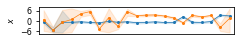

In [33]:
plt.figure(figsize=(3.5,0.5))

for k in range(2):
    plt.fill_between(
        np.arange(f1, f2),
        ci_stats[f"d/x_{k}"]["ll"][f1:f2], ci_stats[f"d/x_{k}"]["ul"][f1:f2],
        alpha=0.15, color=f"C{k}"
    )
    plt.plot(
        np.arange(f1, f2),
        ci_stats[f"d/x_{k}"]["mean"][f1:f2],
        "o-", ms=2, lw=0.7, color=f"C{k}",
    )

plt.xticks([])
plt.yticks([-6, 0, 6], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylabel(r"$x$", fontsize=8)

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-x.svg")
plt.show()

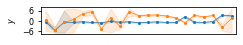

In [34]:
plt.figure(figsize=(3.5,0.5))

for k in range(2):
    plt.fill_between(
        np.arange(f1, f2),
        ci_stats[f"d/x_{k}"]["ll"][f1:f2], ci_stats[f"d/x_{k}"]["ul"][f1:f2],
        alpha=0.15, color=f"C{k}"
    )
    plt.plot(
        np.arange(f1, f2),
        ci_stats[f"d/x_{k}"]["mean"][f1:f2],
        "o-", ms=2, lw=0.7, color=f"C{k}",
    )

plt.xticks([])
plt.yticks([-6, 0, 6], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylabel(r"$y$", fontsize=8)

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-y.svg")
plt.show()

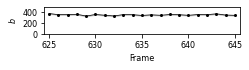

In [35]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    ci_stats["d/background"]["mean"][f1:f2],
    "o-", ms=2, lw=0.7, color="k"
)
plt.fill_between(
    np.arange(f1, f2),
    ci_stats["d/background"]["ll"][f1:f2], ci_stats["d/background"]["ul"][f1:f2],
    alpha=0.15, color="k"
)

plt.xticks(np.arange(f1, f2+5, 5), fontsize=8)
plt.yticks([0, 200, 400], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(0, 500)
plt.ylabel(r"$b$", fontsize=8)
#plt.legend(fontsize=8)
plt.xlabel("Frame", fontsize=8)

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/grace-b.svg")
plt.show()

### Figure 4

In [36]:
model.n = None
predictive = Predictive(pyro.poutine.uncondition(model.model), guide=model.guide, num_samples=1)
samples = predictive()

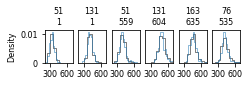

In [37]:
aois = [51, 131, 51, 131, 163, 76]
frames = [1, 1, 559, 604, 635, 535]

plt.figure(figsize=(3.5, 0.6))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    plt.title(f"{n}\n{f}", fontsize=8)
    plt.hist(
        model.data[n, f].flatten().numpy(),
        range=(200, model.data.vmax+150),
        density=True, bins=10, histtype="step", lw=0.5, color="k")
    plt.hist(
        samples["d/data"][0, n, f].flatten().numpy(),
        range=(200, model.data.vmax+150),
        density=True, bins=20, histtype="step", lw=0.5, color="C0")
    plt.xlim(200, model.data.vmax+150)
    plt.xticks([300, 600], fontsize=8)
    if i == 0:
        plt.yticks(fontsize=8)
        plt.ylabel("Density", fontsize=8)
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
    else:
        plt.yticks([])

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/grace-hist.svg")

plt.show()

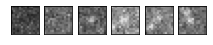

In [38]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    
    plt.imshow(model.data[n, f].numpy(), vmin=200, vmax=model.data.vmax+150, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/grace-data.png", dpi=600)

plt.show()

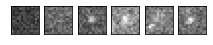

In [39]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    plt.imshow(samples["d/data"][0, n, f].numpy(), vmin=200, vmax=model.data.vmax+150, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/grace-sample.png", dpi=600)

plt.show()

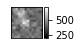

In [40]:
plt.figure(figsize=(0.7, 0.7))

plt.imshow(model.data[n, f].numpy(), vmin=200, vmax=model.data.vmax+150, cmap="gray")
plt.xticks([], [])
plt.yticks([], [])

plt.colorbar(aspect=7, shrink=0.8)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/grace-colorbar.svg")

plt.show()

### Extended Data Figure 3

#### Rastegram

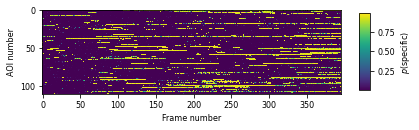

In [49]:
path_data = Path("/shared/centaur/data/GraceArticlePol2/")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs16"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

# on-target
ttfb = time_to_first_binding(model.z_map)
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

plt.figure(figsize=(6, 2))
plt.imshow(model.z_marginal[::3, ::2], aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.show()

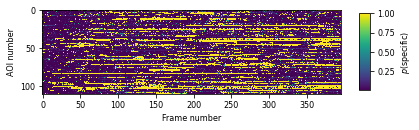

In [50]:
# off-target
plt.figure(figsize=(6, 2))
plt.imshow(1 - (1 - model.j_probs[:, ::3, ::2]).prod(0), aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.show()

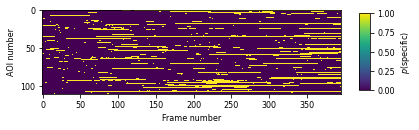

In [51]:
# spotpicker
plt.figure(figsize=(6, 2))
plt.imshow(model.data.labels["z"][::3, ::2], aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.show()

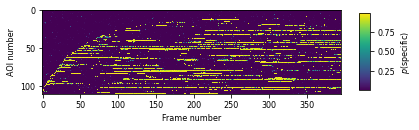

In [52]:
# sorted on-target
ttfb = time_to_first_binding(model.z_map)
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

plt.figure(figsize=(6, 2))
plt.imshow(model.z_marginal[sdx][::3, ::2], aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure3/grace-rastegram.png", dpi=900)
plt.show()

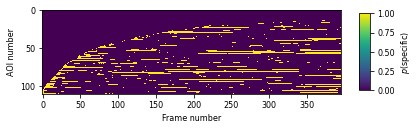

In [53]:
# sorted spotpicker
ttfb = time_to_first_binding(model.data.labels["z"])
# sort ttfb
sdx = np.flip(np.argsort(ttfb))

plt.figure(figsize=(6, 2))
plt.imshow(model.data.labels["z"][sdx][::3, ::2], aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.show()

#### Tapqir fit

In [22]:
z_marginal = model.z_marginal.data
control = None
Tmax = model.data.F

z = dist.Bernoulli(z_marginal).sample((1000,))
data = time_to_first_binding(z)

In [23]:
train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=data, control=control, Tmax=Tmax, jit=True
)

/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/unit.py:23: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  log_factor = torch.as_tensor(log_factor)
/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/util.py:181: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif reversed_shape[i] == 1 and not strict:
/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/util.py:183: TracerWarning: Converting a tensor to a Python 

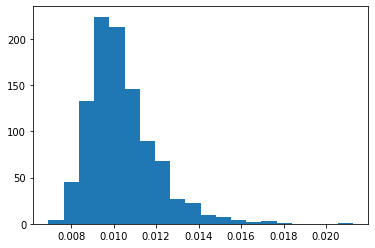

In [24]:
plt.hist(pyro.param("ka").data.squeeze().numpy(), bins=20)
plt.show()

In [25]:
ka_mean = pyro.param("ka").data.mean() / 2.997
ka_ll, ka_ul = pi(pyro.param("ka").data.squeeze(), 0.68, dim=0) / 2.997
ka_mean, ka_ll, ka_ul

(tensor(0.0035), tensor(0.0030), tensor(0.0039))

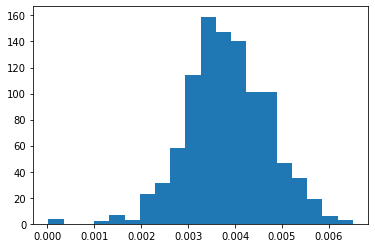

In [26]:
plt.hist(pyro.param("kns").data.squeeze().numpy(), bins=20)
plt.show()

In [27]:
kns_mean = pyro.param("kns").data.mean() / 2.997
kns_ll, kns_ul = pi(pyro.param("kns").data.squeeze(), 0.68, dim=0) / 2.997
kns_mean, kns_ll, kns_ul

(tensor(0.0013), tensor(0.0010), tensor(0.0016))

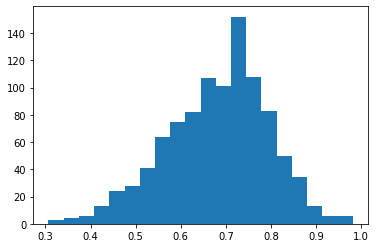

In [28]:
plt.hist(pyro.param("Af").data.squeeze().numpy(), bins=20)
plt.show()

In [29]:
Af_mean = pyro.param("Af").data.mean()
Af_ll, Af_ul = pi(pyro.param("Af").data.squeeze(), 0.68, dim=0)
Af_mean, Af_ll, Af_ul

(tensor(0.6815), tensor(0.5660), tensor(0.7893))

In [30]:
nz = (data == 0).sum(1, keepdim=True)
n = (data == Tmax).sum(1, keepdim=True)
N = data.shape[1]

In [31]:
fraction_bound = (data.unsqueeze(-1) < torch.arange(Tmax)).float().mean(1)
fb_ll, fb_ul = pi(fraction_bound, 0.68, dim=0)

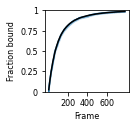

In [32]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(Tmax)

plt.fill_between(
    torch.arange(Tmax),
    fb_ll, fb_ul,
    alpha=0.3, color="C0"
)
plt.plot(torch.arange(Tmax), fraction_bound.mean(0))


plt.plot(
    torch.arange(Tmax),
    (nz / N +
    (1 - nz / N) *
    (pyro.param("Af").data*(1 - np.exp(-(pyro.param("ka")+pyro.param("kns")).data * torch.arange(Tmax))) +
    (1 - pyro.param("Af").data)*(1 - np.exp(-pyro.param("kns").data * torch.arange(Tmax))))).mean(0),
    color="k"
)

plt.xticks([200, 400, 600], fontsize=8)
plt.yticks(fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel("Frame", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure3/grace-tapqir.svg")
plt.show()

#### Spotpicker fit

In [45]:
Tmax = model.data.F

spotpicker_data = time_to_first_binding(model.data.labels["z"])
spotpicker_data = torch.tensor(spotpicker_data, dtype=torch.float)
spotpicker_control = time_to_first_binding(model.control.labels["z"])
spotpicker_control = torch.tensor(spotpicker_control, dtype=torch.float)

bootstrap_data = torch.stack(
    [resample(spotpicker_data, num_samples=len(spotpicker_data), replacement=True) for _ in range(1000)],
    dim=0
)
bootstrap_control = torch.stack(
    [resample(spotpicker_control, num_samples=len(spotpicker_control), replacement=True) for _ in range(1000)],
    dim=0
)

In [46]:
train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=bootstrap_data, control=bootstrap_control, Tmax=Tmax, jit=True
)

/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/unit.py:23: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  log_factor = torch.as_tensor(log_factor)
/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/unit.py:23: TracerWarning: torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  log_factor = torch.as_tensor(log_factor)
/home/ordabayev/anaconda3/envs/tapqir/lib/python3.8/site-packages/pyro/distributions/util.py:181: TracerWarn

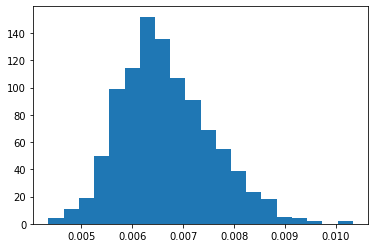

In [6]:
plt.hist(pyro.param("ka").data.squeeze().numpy(), bins=20)
plt.show()

In [7]:
ka_mean = pyro.param("ka").data.mean() / 2.997
ka_ll, ka_ul = pi(pyro.param("ka").data.squeeze(), 0.68, dim=0) / 2.997
ka_mean, ka_ll, ka_ul

(tensor(0.0022), tensor(0.0019), tensor(0.0025))

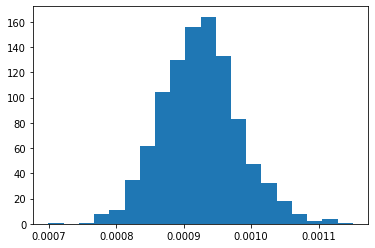

In [8]:
plt.hist(pyro.param("kns").data.squeeze().numpy(), bins=20)
plt.show()

In [9]:
kns_mean = pyro.param("kns").data.mean() / 2.997
kns_ll, kns_ul = pi(pyro.param("kns").data.squeeze(), 0.68, dim=0) / 2.997
kns_mean, kns_ll, kns_ul

(tensor(0.0003), tensor(0.0003), tensor(0.0003))

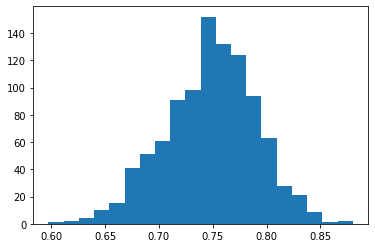

In [10]:
plt.hist(pyro.param("Af").data.squeeze().numpy(), bins=20)
plt.show()

In [11]:
Af_mean = pyro.param("Af").data.mean()
Af_ll, Af_ul = pi(pyro.param("Af").data.squeeze(), 0.68, dim=0)
Af_mean, Af_ll, Af_ul

(tensor(0.7483), tensor(0.7042), tensor(0.7902))

In [12]:
nz = (bootstrap_data == 0).sum(1, keepdim=True)
n = (bootstrap_data == Tmax).sum(1, keepdim=True)
N = bootstrap_data.shape[1]

nzc = (bootstrap_control == 0).sum(1, keepdim=True)
nc = (bootstrap_control == Tmax).sum(1, keepdim=True)
Nc = bootstrap_control.shape[1]

In [13]:
fraction_bound = (bootstrap_data.unsqueeze(-1) < torch.arange(Tmax)).float().mean(1)
fb_ll, fb_ul = pi(fraction_bound, 0.68, dim=0)

fraction_boundc = (bootstrap_control.unsqueeze(-1) < torch.arange(Tmax)).float().mean(1)
fbc_ll, fbc_ul = pi(fraction_boundc, 0.68, dim=0)

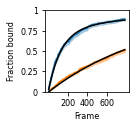

In [19]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(Tmax)

plt.fill_between(
    torch.arange(Tmax),
    fb_ll, fb_ul,
    alpha=0.3, color="C0"
)
plt.plot(torch.arange(Tmax), fraction_bound.mean(0))


plt.plot(
    torch.arange(Tmax),
    (nz / N +
    (1 - nz / N) *
    (pyro.param("Af").data*(1 - np.exp(-(pyro.param("ka")+pyro.param("kns")).data * torch.arange(Tmax))) +
    (1 - pyro.param("Af").data)*(1 - np.exp(-pyro.param("kns").data * torch.arange(Tmax))))).mean(0),
    color="k"
)

plt.fill_between(
    torch.arange(Tmax),
    fbc_ll, fbc_ul,
    alpha=0.3, color="C1"
)
plt.plot(torch.arange(Tmax), fraction_boundc.mean(0))


plt.plot(
    torch.arange(Tmax),
    (nzc / Nc +
    (1 - nzc / Nc) *
    (1 - np.exp(-pyro.param("kns").data * torch.arange(Tmax)))).mean(0),
    color="k"
)

plt.xticks([200, 400, 600], fontsize=8)
plt.yticks(fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel("Frame", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/extended-data/figure3/grace-spotpicker.svg")
plt.show()

Time to first binding

$$ \mathrm{ttfb} = \sum_{f=1}^{F-1} f z_{n,f} \prod_{f^\prime=0}^{f-1} (1 - z_{n,f^\prime})
    + F \prod_{f^\prime=0}^{F-1} (1 - z_{n,f^\prime}) $$

$$ \mathbb{E}[\mathrm{ttfb}] = \sum_{f=1}^{F-1} f q(z_{n,f}=1) \prod_{f^\prime=f-1}^{f-1} q(z_{n,f^\prime}=0)
    + F \prod_{f^\prime=0}^{F-1} q(z_{n,f^\prime}=0) $$

### HMM

In [129]:
path_data = Path("/shared/centaur/data/test/GraceArticlePol2/")
path_params = path_data / "runs/hmm/v1.1.6/S1/control/lr0.005/bs16"

# load parameters
hmm = HMM(S=1, K=2)
hmm.load(path_data, True, "cpu")
hmm.load_parameters(path_params)

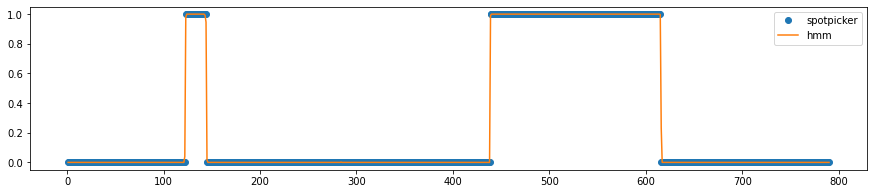

In [132]:
n = 9
plt.figure(figsize=(15,3))
plt.plot(hmm.data.drift.index, hmm.data.labels["z"][n], "o", label="spotpicker")
plt.plot(hmm.data.drift.index, hmm.z_marginal[n], "-", label="hmm")
plt.legend()
plt.show()

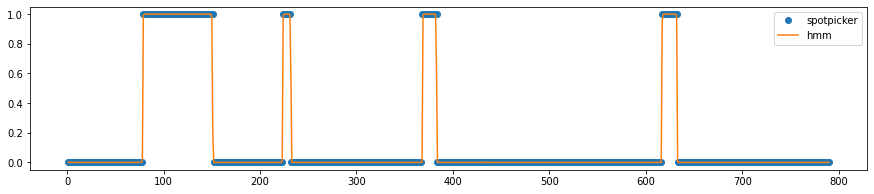

In [133]:
n = 11
plt.figure(figsize=(15,3))
plt.plot(hmm.data.drift.index, hmm.data.labels["z"][n], "o", label="spotpicker")
plt.plot(hmm.data.drift.index, hmm.z_marginal[n], "-", label="hmm")
plt.legend()
plt.show()

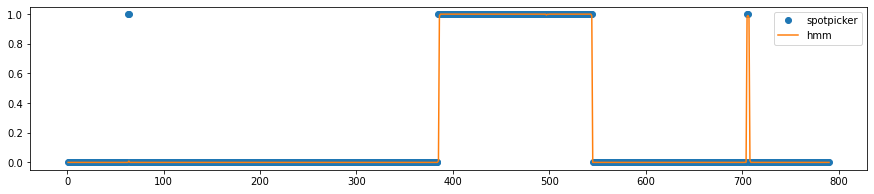

In [134]:
n = 20
plt.figure(figsize=(15,3))
plt.plot(hmm.data.drift.index, hmm.data.labels["z"][n], "o", label="spotpicker")
plt.plot(hmm.data.drift.index, hmm.z_marginal[n], "-", label="hmm")
plt.legend()
plt.show()

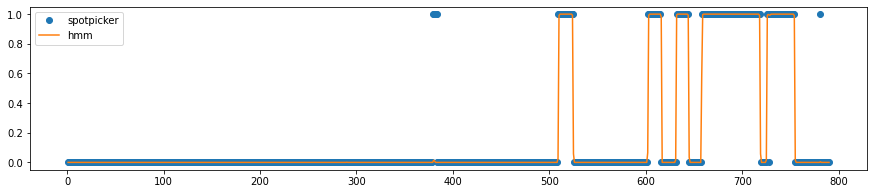

In [137]:
n = 12
plt.figure(figsize=(15,3))
plt.plot(hmm.data.drift.index, hmm.data.labels["z"][n], "o", label="spotpicker")
plt.plot(hmm.data.drift.index, hmm.z_marginal[n], "-", label="hmm")
plt.legend()
plt.show()

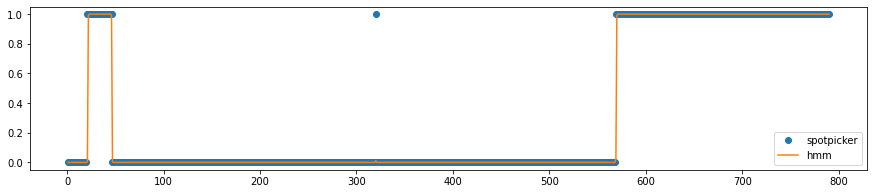

In [139]:
n = 150
plt.figure(figsize=(15,3))
plt.plot(hmm.data.drift.index, hmm.data.labels["z"][n], "o", label="spotpicker")
plt.plot(hmm.data.drift.index, hmm.z_marginal[n], "-", label="hmm")
plt.legend()
plt.show()

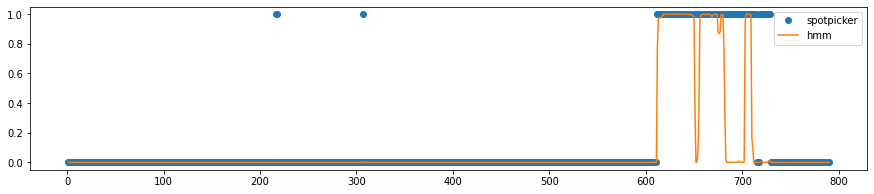

In [140]:
n = 200
plt.figure(figsize=(15,3))
plt.plot(hmm.data.drift.index, hmm.data.labels["z"][n], "o", label="spotpicker")
plt.plot(hmm.data.drift.index, hmm.z_marginal[n], "-", label="hmm")
plt.legend()
plt.show()

## Appendix

$$ p(\mathbf{z}) = \prod_{n=0}^{N-1} p(z_{n,0}|\pi) \prod_{f=1}^{F-1} p(z_{n,f}|z_{n,f-1}, A) $$

$$ \log p(\mathbf{z}) = \sum_{n=0}^{N-1} \left ( \log p(z_{n,0}|\pi) + \sum_{f=1}^{F-1} \log p(z_{n,f}|z_{n,f-1}, A_{01}, A_{10}) \right ) $$

$$ \log p(\mathbf{z}) = \sum_{n=0}^{N-1} \left ( (1-z_{n,0}) \log (1-\pi) + z_{n,0} \log \pi +
    \sum_{f=1}^{F-1} \left (
        (1 - z_{n,f-1}) (1 - z_{n,f}) \log (1 - \frac{A_{01}}{2})
        + (1-z_{n,f-1}) z_{n,f} \log \frac{A_{01}}{2}
        + z_{n,f-1} (1 - z_{n,f}) \log \frac{1+A_{10}}{2}
        + z_{n,f-1} z_{n,f} \log (1 - A_{10}) \right ) \right ) $$

$$ \log p(\mathbf{z}) = \sum_{n=0}^{N-1} \left ( (1-z_{n,0}) \log (1-\pi) + z_{n,0} \log \pi +
    \sum_{f=1}^{F-1} \left (
        (1 - z_{n,f-1}) (1 - z_{n,f}) \log (1 - A_{01})
        + (1-z_{n,f-1}) z_{n,f} \log A_{01}
        + z_{n,f-1} (1 - z_{n,f}) \log A_{10}
        + z_{n,f-1} z_{n,f} \log (1 - A_{10}) \right ) \right ) $$

$$ \dfrac{\partial \log p(\mathbf{z})}{\partial \pi}
 = \sum_{n=0}^{N-1} \left ( -\dfrac{1-z_{n,0}}{1-\pi} + \dfrac{z_{n,0}}{\pi} \right ) = 0 $$
 
$$ \sum_{n=0}^{N-1} \left ( \dfrac{(1-\pi) z_{n,0} - \pi (1-z_{n,0})}{\pi (1-\pi)} \right ) = 0 $$

$$ \dfrac{\partial \log p(\mathbf{z})}{\partial A_{01}}
 = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \left (
     \dfrac{-(1-z_{n,f-1})(1-z_{n,f})}{1-A_{01}}
     + \dfrac{(1-z_{n,f-1})z_{n,f}}{A_{01}} \right ) = 0 $$

$$ \sum_{n=0}^{N-1} \left ( z_{n,0} - \pi \right ) = 0 $$

$$ \pi = \dfrac{1}{N} \sum_{n=0}^{N-1} z_{n,0} $$

$$ \mathbb{E}_{q(\mathbf{z})} \left [ \pi \right ] = \dfrac{1}{N} \sum_{n=0}^{N-1} q(z_{n,0}=1) $$

$$ \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \left ( (1-A_{01}) (1-z_{n,f-1})z_{n,f} - A_{01} (1-z_{n,f-1})(1-z_{n,f}) \right ) = 0 $$

$$ \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) z_{n,f} - \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) A_{01} = 0 $$

$$ \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) z_{n,f} = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) A_{01} $$

$$ A_{01} = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \dfrac{(1-z_{n,f-1}) z_{n,f}}{\sum_{n^\prime=0}^{N-1} \sum_{f^\prime=1}^{F-1} (1-z_{n^\prime,f^\prime-1})} $$

$$ A_{10} = \dfrac{\sum_n^N \sum_f^F z_{n,f} (1-z_{n,f+1})}{\sum_n^N \sum_f^F z_{n,f}} $$

$$ \mathbb{E}_{q(\mathbf{z})} \left [ A_{01} \right ]
    = \sum_\mathbf{z} \sum_n^N \sum_f^F \dfrac{(1-z_{n,f}) z_{n,f+1}}{\sum_{n^\prime}^N \sum_{f^\prime}^F (1-z_{n^\prime,f^\prime})} q(\mathbf{z}) $$

$$  = \sum_n^N \sum_f^F q(z_{n,f}=0) q(z_{n,f+1}=1) \sum_{\mathbf{z} \backslash z_{n,f},z_{n,f+1}}
    \dfrac{1}{1 + 0 + \sum_{n^\prime}^N \sum_{f^\prime}^F (1-z_{n^\prime,f^\prime})} q(\mathbf{z}) $$